In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as pltsns
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2grey
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

In [2]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class = 2000
fixed_size       = tuple((342, 256))
train_path       = "dataset/train"
h5_data          = '/home/zxt/code/flower/output/data.h5'
h5_labels        = '/home/zxt/code/flower/output/labels.h5'
bins             = 8

In [3]:
df = pd.read_csv('/home/zxt/data/final_22/ml/df_all_2000.csv',index_col=0)

In [4]:
df.head(2)

,image_id,label
235214,587eeb45-23d2-11e8-a6a3-ec086b02610b.jpg,empty
236262,5a0b00ef-23d2-11e8-a6a3-ec086b02610b.jpg,empty


In [5]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [6]:
img_path = '/home/zxt/data/all/resized_data/'

In [7]:
imglist = list(df['image_id'])

In [8]:
global_features = []
labels =list(df['label'])
count = 0

for i in imglist:
    dir = img_path+i
    image =cv2.imread(dir)
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image) 
    fv_histogram  = fd_histogram(image)
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    global_features.append(global_feature)
    count +=1
    if count % 1000 ==0:
        print(count)                          

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000


In [9]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] feature vector size (44000, 532)
[STATUS] training Labels (44000,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [6 6 6 ... 1 1 1]
[STATUS] target labels shape: (44000,)
[STATUS] end of training..


In [10]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.10
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = ['elephant','wild_boar','gazellethomosons','squirrel','hedgehog','guineafowl','moose','coyote','bird',
                  'fox','giraffe','buffalo','hare','vehicle','wildebeest','cattle','skunk','lion','zebra','black_bear',
                  'racoon']
# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
# models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
# models.append(('SVM', SVC(random_state=seed)))
# models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
# models.append(('NB', GaussianNB()))


# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (44000, 532)
[STATUS] labels shape: (44000,)
[STATUS] training started...


/home/zxt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (39600, 532)
Test data   : (4400, 532)
Train labels: (39600,)
Test labels : (4400,)


LR: 0.429975 (0.005798)
KNN: 0.589773 (0.008560)
RF: 0.712121 (0.006078)


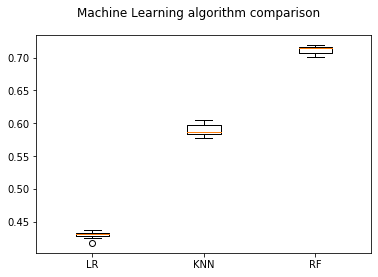

In [12]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [13]:
# pick RF 
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# predict test set
prediction = clf.predict(testDataGlobal)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(testLabelsGlobal,prediction)

0.7306818181818182

### confusion matrix

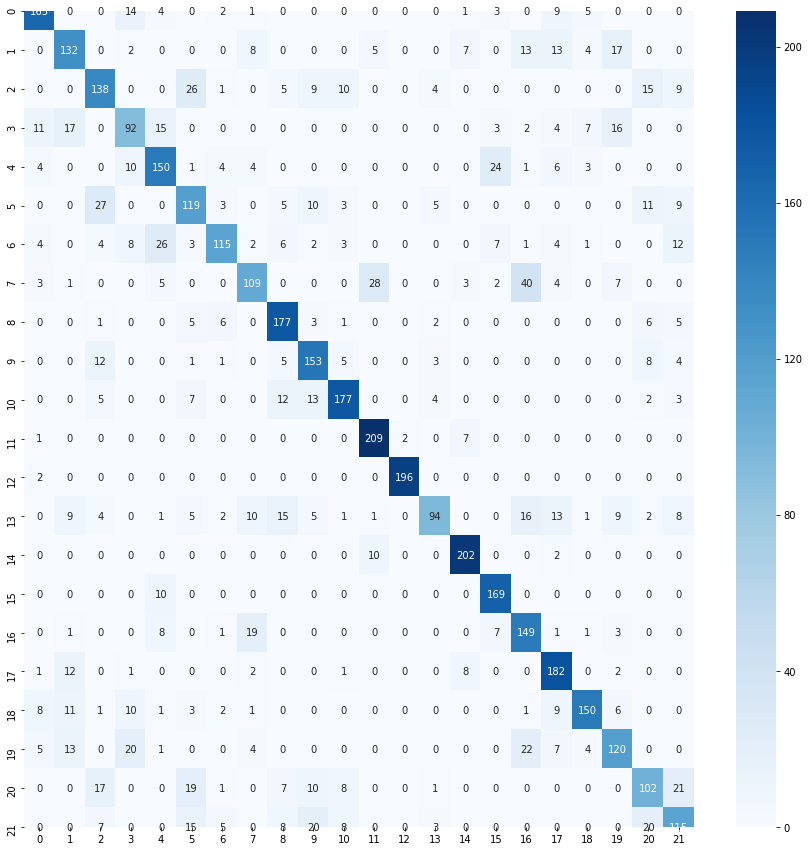

In [23]:
C2=confusion_matrix(testLabelsGlobal,prediction, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
pyplot.figure(figsize=(15,15))
# pyplot.
sns.heatmap(C2,annot=True,cmap="Blues",fmt='.20g')

In [24]:
animal_label_dict = {0:'elephant',1:'wild_boar',2:'gazellethomosons',3:'squirrel',4:'hedgehog',
                    5:'guineafowl',6:'moose',7:'coyote',8:'bird',9:'fox',10:'giraffe',
                    11:'buffalo',12:'hare',13:'vehicle',14:'wildebeest',15:'cattle',
                    16:'skunk',17:'lion',18:'zebra',19:'black_bear',20:'racoon',21:'empty'}     
labels=[]
for i in range(0,22):
    name = animal_label_dict[i]
    labels.append(name)

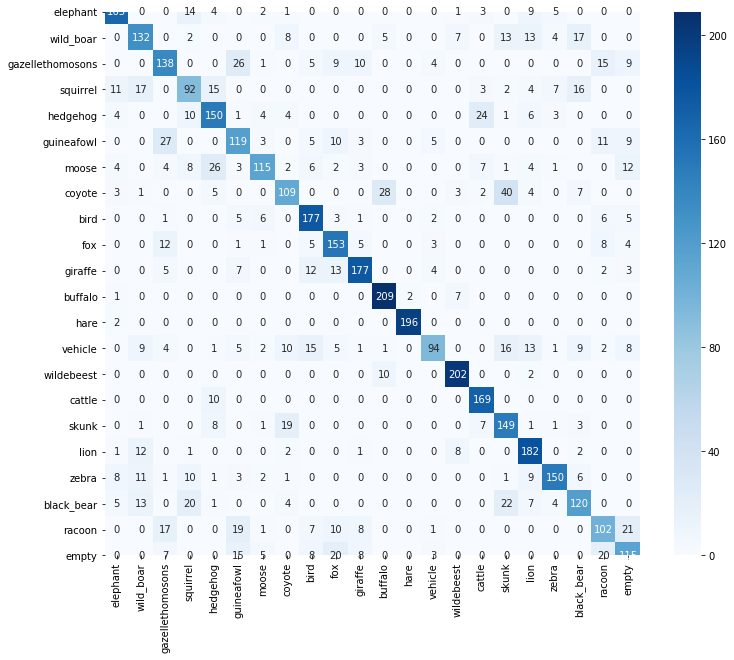

In [27]:
# C2=confusion_matrix(test_true_label,prediction_label, labels=labels)
C2=confusion_matrix(testLabelsGlobal,prediction, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
pyplot.figure(figsize=(12,10))
sns.heatmap(C2,annot=True,cmap="Blues",xticklabels=labels,yticklabels=labels,fmt='.20g')